# Simple Harmonic Oscillator

This example implements a simple harmonic oscillator in a 2-dimensional neural
population. The oscillator is more visually interesting than the integrator as it is
able to indefinitely sustain an oscillatory behaviour without further input to the
system (once the oscillator has been initialized).

Constructing an oscillator with a neural population follows the same process as with the
integrator. Recall that the dynamics of a state vector can be described with:
$$
\dot{x}(t) = \mathbf{A}x(t) + \mathbf{B}u(t)
$$

For an oscillator,
$$
\begin{align}
    \mathbf{A} &= \begin{bmatrix}
                       0 && \omega \\
                       -\omega && 0
                  \end{bmatrix} \\
    \mathbf{B} &= 0
\end{align}
$$

where the frequency of the oscillation is $\frac{\omega}{2\pi}$ Hz.

As with the integrator example, the neural equivalent of the input and feedback matrices
can be computed:
$$
\begin{align}
    \mathbf{A}' &= \tau\mathbf{A} + \mathbf{I} \\
    &= \tau\begin{bmatrix}
               0 && \omega \\
               -\omega && 0
           \end{bmatrix} + \mathbf{I} \\
    &= \begin{bmatrix}
           1 && \tau\cdot\omega \\
           -\tau\cdot\omega && 1
       \end{bmatrix}
\end{align}
$$

The dimensionality of the neural feedback matrix demonstrates why a 2-dimensional neural
population is needed to implement the simple harmonic oscillator. It should also be
noted that, according to the neural input matrix, the neural population implementing the
oscillator requires no input signal.

However, a quick analysis of the feedback matrix reveals that when $x(t) = 0$, the
oscillator is at an unstable equilibrium. Given the randomness in the generation of the
neural population, it is possible for the oscillator to remain at this equilibrium, and
this would be visually uninteresting. Thus, for this example, a quick impulse is
provided to the oscillator to "kick" it into a regime where the oscillatory behaviour
can be observed.

## Step 1: Set up the Python Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML

import nengo
from nengo.processes import Piecewise

from anim_utils import make_anim_simple_osc

import nengo_fpga
from nengo_fpga.networks import FpgaPesEnsembleNetwork

## Step 2: Choose an FPGA Device

Define the FPGA device on which the remote FpgaPesEnsembleNetwork will run. This name
corresponds with the name in your `fpga_config` file. Recall that in the `fpga_config`
file, device names are identified by the square brackets (e.g., **[de1]** or
**[pynq]**). The names defined in your configuration file might differ from the example
below. Here, the device **de1** is being used.

In [2]:
board = "de1"  # Change this to your desired device name

## Step 3: Create the Impulse Input for the Model
Using a piecewise step function, a 100ms impulse is generated as the "kick" signal.

In [3]:
model = nengo.Network(label="Simple Oscillator")
# Create the kick function for input
with model:
    input_node = nengo.Node(Piecewise({0: [1, 0], 0.1: [0, 0]}))

## Step 4: Create the FPGA Ensemble

Create a remote FPGA neural ensemble (`FpgaPesEnsembleNetwork`) using the board defined
above, 200 neurons, 2 dimensions, and with no learning rate. We will also specify the
recurrent connection here.

In [4]:
tau = 0.1  # Synaptic time constant (s)
freq = 1  # Oscillation frequency (Hz)
w = freq * 2 * np.pi  # Omega

with model:
    # Remote FPGA neural ensemble
    fpga_ens = FpgaPesEnsembleNetwork(
        board,  # The board to use (from above)
        n_neurons=200,  # The number of neurons to use in the ensemble
        dimensions=2,  # 2 dimensions
        learning_rate=0,  # No learning for this example
        feedback=1,  # Activate the recurrent connection
    )

    # Setting `feedback=1` creates a `feedback` connection object
    # with the identity transform. To implement the oscillator, it
    # is necessary to set the transform on the feedback connection
    # using .transform.
    fpga_ens.feedback.synapse = tau  # `nengo.LowPass(tau)`
    fpga_ens.feedback.transform = [[1, tau * w], [-tau * w, 1]]

Specified FPGA configuration 'de1' not found.


## Step 5: Connect Everything Together
The recurrent connection is housed on the FPGA device and is created as part of the
`FpgaPesEnsembleNetwork` object, so the only connection that needs to be made is the
input stimulus to the FPGA ensemble.

In [5]:
with model:
    # Connect the stimulus
    nengo.Connection(input_node, fpga_ens.input, synapse=tau, transform=1)

## Step 6: Add Probes to Collect Data

In [6]:
with model:
    # The original input
    input_p = nengo.Probe(input_node)

    # The output from the FPGA ensemble
    # (filtered with a 10ms post-synaptic filter)
    output_p = nengo.Probe(fpga_ens.output, synapse=0.01)

## Step 7: Run the Model

In [7]:
with nengo_fpga.Simulator(model) as sim:
    sim.run(5)

Building network with dummy (non-FPGA) ensemble.


## Step 8: Plot the Results

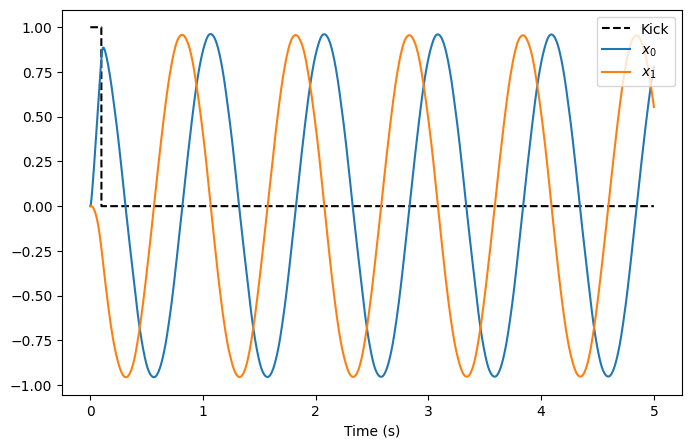

In [8]:
def plot_results():
    plt.figure(figsize=(8, 5))
    plt.plot(sim.trange(), sim.data[input_p][:, 0], "k--")
    plt.plot(sim.trange(), sim.data[output_p])
    plt.legend(["Kick", "$x_0$", "$x_1$"], loc="upper right")
    plt.xlabel("Time (s)")
    plt.show()


plot_results()

The plot above shows that the interaction of the two dimensions of the oscillator cause
the decoded output of the oscillator to exhibit the desired oscillatory behaviour. From
the plot, it can be seen that the oscillation frequency is approximately 1Hz, as
specified in the code.

While a static plot is somewhat informative, the behaviour of the oscillator becomes
more apparent by plotting the first dimension of the output against the second dimension
of the output. To make the behaviour more striking, the code below animates the
2-dimensional plot. It may take a moment to generate the animation.

In [9]:
def make_anim():
    _, _, anim = make_anim_simple_osc(
        sim.data[output_p][:, 0], sim.data[output_p][:, 1]
    )
    return anim


HTML(make_anim().to_html5_video())

## Step 9: Spiking Neurons

The plots above demonstrate the results of a simple oscillator implemented in a network
of non-spiking rectified linear neurons. The network can also be simulated using spiking
neurons to illustrate the similarities and differences between a spiking and a
non-spiking network.

Below, we configure the FPGA neural ensemble to use spiking neurons, run the simulation,
and plot the results.

Building network with dummy (non-FPGA) ensemble.


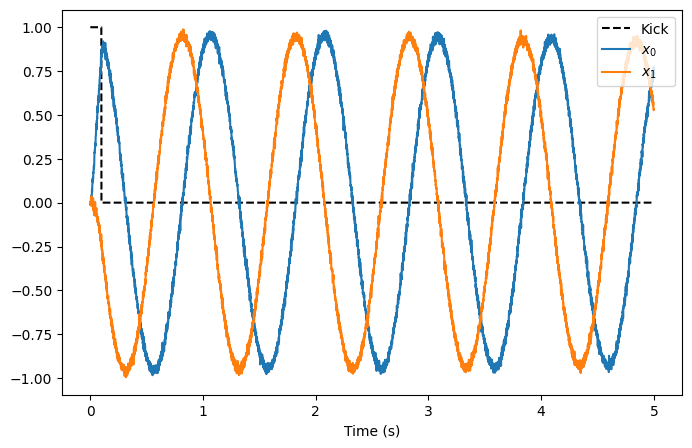

In [10]:
with model:
    fpga_ens.ensemble.neuron_type = nengo.SpikingRectifiedLinear()

with nengo_fpga.Simulator(model) as sim:
    sim.run(5)
plot_results()

In [11]:
HTML(make_anim().to_html5_video())

The plots above show that with spiking neurons, the output of the network is,
expectedly, more noisy (less precise) than the results of the non-spiking network.
However, despite this, the oscillator network in its current configuration is stable
even with the spikes adding additional noise into the system.

It should be noted that the output of the spiking network might differ from the output
of the non-spiking network because the network parameters are regenerated (randomized)
when a new Nengo simulation is created.

## Step 10: Experiment!

Try playing around with the number of neurons in the FPGA ensemble as well as the
synaptic time constant (`tau`) to see how it effects performance (e.g., observe how
changing these numbers affect the stability of the oscillator)! Additionally, modify the
oscillation frequency (try making it negative) to its impact on the output. You can also
change the simulation time and see how long the oscillator is stable for!

Perform these experiments for both the non-spiking and spiking networks, and observe how
the additional noise introduced by the spikes affect the performance of the network with
relation to the various network and oscillator parameters.